In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils import epsilon_greedy_policy, initialize_q_table, rec_state, rec_state_path, get_best_params
from RLOpt import ObjModel, train

In [2]:
# Environment parameters
params = {
            'penalty': ['l2', 'l1', 'elasticnet'], 
            'loss': ['log', 'hinge', 'modified_huber', 'squared_hinge', 'perceptron'],
            'random_state': [0],
            'alpha': np.arange(0.0001, 0.01, 0.001)
        }
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
data = (X_train, y_train, X_test, y_test)
env = ObjModel(SGDClassifier, params, data)     # environment
# Training parameters
learning_rate = 1          # Learning rate
max_steps = 20            # Max steps per episode
gamma = 0.9                 # Discounting rate

# Exploration parameters
epsilon = 1.0
decay_rate = 0.005            # Exponential decay rate for exploration prob

In [3]:
state_space = env.observation_space_n # TODO
action_space = env.action_space_n # TODO
Qtable_init_s = initialize_q_table(state_space, action_space)

Qtable_s, episod_rewards_s = train(epsilon, decay_rate, env, max_steps, Qtable_init_s, gamma, learning_rate)

params = get_best_params(Qtable_s, env, calc_acc=True)

In [4]:
accs = [i[1] for i in params]
print(accs, 'best acc:', np.max(accs))

[0.98, 1.0, 0.98] best acc: 1.0


In [5]:
print('best params:', params[np.argmax(accs)][0])

best params: {'penalty': 'elasticnet', 'loss': 'modified_huber', 'random_state': 0, 'alpha': 0.0041}


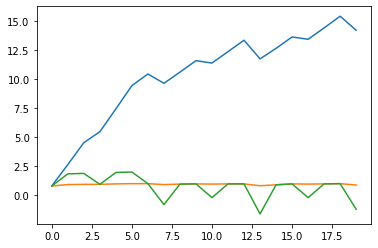

In [6]:
#plt.plot(episod_rewards)
plt.plot(np.cumsum(episod_rewards_s[1]))
plt.plot(episod_rewards_s[0])
plt.plot(episod_rewards_s[1])